# Про градиентный спуск

Сравнить сложность точного решения задачи линейной регрессии для случая квадратичной ошибки и сложность решения этой же задачи методом градиентного спуска (при условии, что градиентный спуск сходится с K шагов, в задаче есть M признаков и длина обучающей выборки равна N. N>K и N>M)

Градиентный спуск $$O(NDS)$$, где N - длина выборки, D- количество признаков у объекта, S - количество итераций. 
$$O(ND^2 + D^3)$$ - аналитическое решение
 ) 

# Про FWL-Теорему

Кажется, я успешно успел вам наврать на лекции про "отпиливание" зависимости из Y-переменной (я вроде это забыл сказать), поэтому реабилитироваться буду примером:

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.special as sc
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import mpmath
from scipy.stats.sampling import DiscreteGuideTable
from scipy.integrate import quad
import scipy.stats as stats
np.random.seed(42069)
 
# Пусть у нас есть набор данных, где есть линейная зависимость y от X1 и X2
# При этом X1 и X2 тоже малясь зависимые
df = pd.DataFrame({'x1': np.random.uniform(0, 10, size=1000)})
df['x2'] = 4.9 + df['x1'] * 0.983 + 2.104 * np.random.normal(0, 1.35, size=1000)
df['y'] = 8.643 - 2.34 * df['x1'] + 3.35 * df['x2'] + np.random.normal(0, 1.65, size=1000)
df['const'] = 1
 
# Построим линейную регрессию-МНК из 1, X1 и X2
model = sm.OLS(
    endog=df['y'],
    exog=df[['const', 'x1', 'x2']]
).fit()

# Внимательно смотрим на коэффициент при X2
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.754e+04
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:28:50   Log-Likelihood:                -1934.3
No. Observations:                1000   AIC:                             3875.
Df Residuals:                     997   BIC:                             3889.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6842      0.139     62.606      0.000       8.412       8.956
x1            -2.3455      0.027    -88.274      0.000      -2.398      -2.293
x2             3.3544      0.019    178.202      0.000       3.317       3.391
==============================================================================
Omnibus:                        0.497   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.780   Jarque-Bera (JB):                0.394
Skew:                          -0.036   Prob(JB):                        0.821
Kurtosis:                       3.066   Cond. No.                         31.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2]:
# Научим регрессию X1 на X2
model_x2 = sm.OLS(
    endog=df['x2'],
    exog=df[['const', 'x1']]
).fit()

# Научим регрессию X1 на y
model_yx1 = sm.OLS(
    endog=df['y'],
    exog=df[['const', 'x1']]
).fit()

In [3]:
# Полученными регрессиями "предскажем X2 и Y"

df['yx1'] = model_yx1.predict(df[['const', 'x1']])
df['x2x1'] = model_x2.predict(df[['const', 'x1']])
df

,x1,x2,y,const,yx1,x2x1
0,0.305084,8.595233,37.454667,1,24.867577,5.037822
1,4.194086,8.942919,25.227052,1,29.006692,8.991080
2,8.776921,13.448463,32.000686,1,33.884262,13.649634
3,7.135028,7.653533,16.395354,1,32.136774,11.980613
4,3.239823,9.261669,30.338040,1,27.991058,8.021050
...,...,...,...,...,...,...
995,1.577805,8.699299,32.652689,1,26.222151,6.331572
996,8.186401,16.484709,43.966089,1,33.255764,13.049357
997,9.246921,11.438592,23.738685,1,34.384488,14.127398
998,4.609640,6.826222,20.713982,1,29.448971,9.413499


In [4]:
# А затем "отпилим" предсказание из данных
df['y_detrended'] = df['y'] - df['yx1']
df['x2_detrended'] = df['x2'] - df['x2x1']

In [5]:
# Учим модель на "очищенных" переменных и, о Боже, коэффициент при X2 остается "как был"
model_detrended = sm.OLS(
    endog=df['y_detrended'],
    exog=df[['const', 'x2_detrended']]
).fit()
model_detrended.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            y_detrended   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 3.179e+04
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:28:51   Log-Likelihood:                -1934.3
No. Observations:                1000   AIC:                             3873.
Df Residuals:                     998   BIC:                             3882.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.155e-14      0.053  -2.18e-13      1.000      -0.104       0.104
x2_detrended     3.3544      0.019    178.292      0.000       3.318       3.391
==============================================================================
Omnibus:                        0.497   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.780   Jarque-Bera (JB):                0.394
Skew:                          -0.036   Prob(JB):                        0.821
Kurtosis:                       3.066   Cond. No.                         2.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# А теперь задачка :)

Возьмите данные c kaggle, например [отсюда](https://www.kaggle.com/code/malakalaabiad/house-prices-techniques/input) и удостоверьтесь, что FWL-теорема работает, но только не для случая одной переменной :)


In [6]:
df =  pd.read_csv("./hw3_data/boston.csv")
df.insert(1, 'СONST', 1)
df.head(1)

,CRIM,СONST,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,1,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296.0,15.3,396.9,4.98,24.0


In [7]:
Y = df["MEDV"]
X = df.iloc[:,:-1]
X1 = df.loc[:,:"RAD"]
X2 = df.loc[:,"TAX":"LSTAT"]
X2

,TAX,PTRATIO,B,LSTAT
0,296.0,15.3,396.90,4.98
1,242.0,17.8,396.90,9.14
2,242.0,17.8,392.83,4.03
3,222.0,18.7,394.63,2.94
4,222.0,18.7,396.90,5.33
...,...,...,...,...
501,273.0,21.0,391.99,9.67
502,273.0,21.0,396.90,9.08
503,273.0,21.0,396.90,5.64
504,273.0,21.0,393.45,6.48


In [8]:
model_full = sm.OLS(Y, X).fit()
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          6.72e-135
Time:                        19:28:51   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.1080      0.033     -3.287      0.001      -0.173      -0.043
СONST         36.4595      5.103      7.144      0.000      26.432      46.487
ZN             0.0464      0.014      3.382      0.001       0.019       0.073
INDUS          0.0206      0.061      0.334      0.738      -0.100       0.141
CHAS           2.6867      0.862      3.118      0.002       0.994       4.380
NOX          -17.7666      3.820     -4.651      0.000     -25.272     -10.262
RM             3.8099      0.418      9.116      0.000       2.989       4.631
AGE            0.0007      0.013      0.052      0.958      -0.025       0.027
DIS           -1.4756      0.199     -7.398      0.000      -1.867      -1.084
RAD            0.3060      0.066      4.613      0.000       0.176       0.436
TAX           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
PTRATIO       -0.9527      0.131     -7.283      0.000      -1.210      -0.696
B              0.0093      0.003      3.467      0.001       0.004       0.015
LSTAT         -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
model_part_1 = sm.OLS(Y, X1).fit()
residuals_Y = model_part_1.resid

In [10]:
model_part_2 = sm.OLS(X2, X1).fit()
residuals_X12 = model_part_2.resid
#добавляем ещё раз константу
residuals_X12 = sm.add_constant(residuals_X12)

In [11]:
final = sm.OLS(residuals_Y, residuals_X12).fit()
final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     52.49
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           6.26e-37
Time:                        19:28:52   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3008.
Df Residuals:                     501   BIC:                             3029.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.724e-13      0.209   8.25e-13      1.000      -0.411       0.411
TAX           -0.0123      0.004     -3.310      0.001      -0.020      -0.005
PTRATIO       -0.9527      0.130     -7.349      0.000      -1.207      -0.698
B              0.0093      0.003      3.498      0.001       0.004       0.015
LSTAT         -0.5248      0.050    -10.441      0.000      -0.624      -0.426
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                         79.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Про эквивалентность или не эквивалентность разных методов подсчета квантилей

Сгенерируйте 2 выборки длины ,например, 10000 из:

1. Нормального
2. Логнормального
3. Экспоненциального

Распределений с наперед заданными параметрами, так чтобы вы могли однозначно посчитать разницу медиан (используя теорвер и википедию)



Проверьте, какой по этим выборкам будет получаться 95% доверительный интервал на разницу медиан, если его посчитать с помощью:

1. Бутстрепа
2. [Подгонки](https://engineering.atspotify.com/2022/03/comparing-quantiles-at-scale-in-online-a-b-testing/) от Spotify
3. [Подгонки](https://www.evanmiller.org/bootstrapping-sample-medians.html) результатов бутстрепа от Эвана Миллера
4. [Метода Прайса-Боннетта](https://www.tandfonline.com/doi/abs/10.1080/00949650212140)

Что вы можете сказать о работоспособности методов?

(можно попробовать подать на вход какие-то другие распределения, как бы провести "стресс-тест" метода)


In [12]:
def PoissonBootstrap(data, agg_func, n_iter = 1000, alpha =  0.05):

    point_estimation  = agg_func(data)
    data = np.array(data)
    n = len(data)

    weights = np.random.poisson(1, (n_iter, n)) # Пуассоним

    statistics_over_samples = []

    for weight in weights:
        resampled_data = np.repeat(data, weight) # семпл
        statistics_over_samples.append(agg_func(resampled_data))

    return point_estimation, np.array(statistics_over_samples)

In [13]:
alpha=.05
quantile_of_interest=0.5 #равносильно медиане
sample_size=10000
number_of_bootstrap_samples=1000

In [14]:
def BesselProbabilityApproximation(n):
    """
    Будем вычислять вероятность только по бесселевой функции нулего порядка.
    Для выборки порядка 1000 явное вычисление формулы 2*np.exp(-n+1)*sc.ive(0, z) перестаёт работать
    там  получаются числа порядка e^400 от бесселевской функции. Поэтому ive заменил асипмтотикой 
    и  посчитал приближение на бесконенчости
    """
    z  = 2* np.sqrt(np.array([(n-i+1)*i for i in range(1,n+1)]))
    const = 2* np.exp(2)/ np.sqrt(2*np.pi)
    index = np.arange(1, n+1)
    final_arg =  (z - index) - z**2/(4*index)
    return const*(1 + 8/z)*np.exp(final_arg)/np.sqrt(z) 

In [15]:
def BesselProbabilityApproxiamtionIntegral(n):
    base  = 2*np.sqrt(np.array([(n-i+1)*i for i in range(1,n+1)]))
    results = np.zeros_like(base)
    def integrand(t, x):
        return np.exp(x * np.cos(t) - (n-1))
    for i, x in enumerate(base):
        integral, _ = quad(integrand, 0, np.pi, args=(x))
        results[i] = 2*integral / np.pi  # Сохраняем результат в массив
    return np.array(results)

In [16]:
def BesselProbability(n):
    z  = 2*np.sqrt(np.array([(n-i+1)*i for i in range(1,n+1)]))
    probabilitites =  2*np.exp(z-n-1)*sc.ive(0, z)
    return probabilitites

In [17]:
def PriceBonet(sample_1, sample_2, alpha=.05):
    sample_1 = np.sort(sample_1)
    sample_2 = np.sort(sample_2)
    get_c = lambda size: int(np.round(((size + 1) / 2) - (size ** (1/2))))
    c_1 = get_c(len(sample_1))
    c_2 = get_c(len(sample_2))
    var_1 = ((sample_1[len(sample_1) - c_1] - sample_1[c_1]) / 4) ** 2
    var_2 = ((sample_2[len(sample_2) - c_2] - sample_2[c_2]) / 4) ** 2
    diff_med = np.median(sample_1) - np.median(sample_2)
    low_b = diff_med - stats.norm.ppf(1 - (alpha/2)) * (var_1 + var_2) ** (1 / 2)
    up_b = diff_med + stats.norm.ppf(1 - (alpha/2)) * (var_1 + var_2) ** (1 / 2)
    return diff_med, low_b, up_b

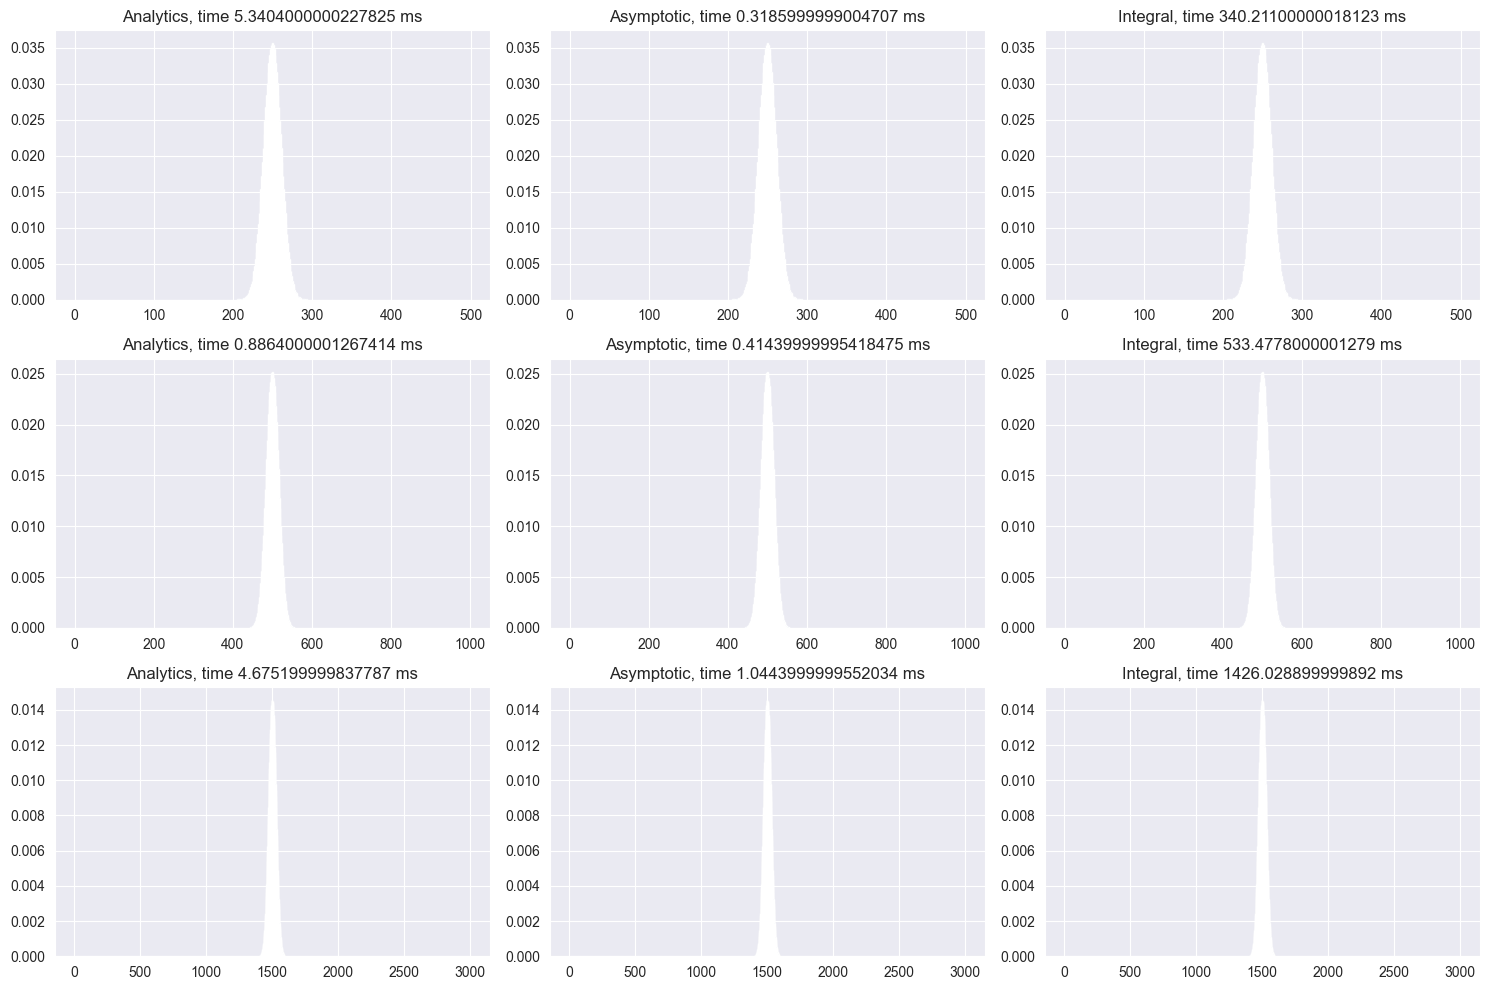

In [18]:
import time

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 1 ряд, 3 столбца
test_size = 500
for i in range(3):
    test_size = test_size*(i+1)
    indexes = np.arange(0, test_size)
    
    start_time = time.perf_counter()
    probabilities = BesselProbability(test_size)
    end_time = time.perf_counter()
    axes[i][0].bar(indexes, probabilities/sum(probabilities))
    axes[i][0].set_title(f'Analytics, time {(end_time-start_time)*1000} ms')

    start_time = time.perf_counter()
    probabilities = BesselProbabilityApproximation(test_size)
    end_time = time.perf_counter()
    axes[i][1].bar(indexes, probabilities/sum(probabilities))
    axes[i][1].set_title(f'Asymptotic, time {(end_time-start_time)*1000} ms')
    
    start_time = time.perf_counter()
    probabilities = BesselProbabilityApproxiamtionIntegral(test_size)
    end_time = time.perf_counter()
    axes[i][2].bar(indexes, probabilities/sum(probabilities))
    axes[i][2].set_title(f'Integral, time {(end_time-start_time)*1000} ms')

# Показываем графики
plt.tight_layout()
plt.show()

In [19]:
def test_methods(alpha,quantile_of_interest,sample_size,number_of_bootstrap_samples, control_sample, treatment_sample,real_diff):
    print("Real difference: ", real_diff)
    pe_control, statistics_control = PoissonBootstrap(control_sample, np.median, number_of_bootstrap_samples)
    pe_treatment, statistics_treatment = PoissonBootstrap(treatment_sample, np.median, number_of_bootstrap_samples)
    poisson_bootstrap_interval = np.quantile(statistics_control- statistics_treatment,[alpha/2 , 1-alpha/2])
    diff_points_estimations  = pe_control-pe_treatment
    print("Sample difference: ", diff_points_estimations)
    print(f"""Poisson bootstrap,
    the {(1-alpha)*100}% confidence interval is given by ({poisson_bootstrap_interval}).""")
    control_sample_sorted = np.sort(control_sample)
    treatment_sample_sorted = np.sort(treatment_sample)
    
    spotify_bootstrap_difference = control_sample_sorted[np.random.binomial(sample_size+1, quantile_of_interest,
    number_of_bootstrap_samples)] - treatment_sample_sorted[np.random.binomial(sample_size+1,
                            quantile_of_interest, number_of_bootstrap_samples)]
    
    spotify_confidence_interval = np.quantile(spotify_bootstrap_difference,
    [alpha/2 , 1-alpha/2])
    
    print(f"""Spotify bootstrap,
    the {(1-alpha)*100}% confidence interval is given by ({spotify_confidence_interval}).""")
    
    probabilities = BesselProbabilityApproximation(sample_size)
    
    probabilities = probabilities/sum(probabilities)
    rng = np.random.default_rng(0)
    dist_1 = DiscreteGuideTable(probabilities, random_state=rng)
    dist_2 = DiscreteGuideTable(probabilities, random_state=rng)
    dist_indexes_1 = dist_1.rvs(size=number_of_bootstrap_samples)
    dist_indexes_2 = dist_2.rvs(size=number_of_bootstrap_samples)
    miller_bootstrap_difference = control_sample_sorted[dist_indexes_1] -treatment_sample_sorted[dist_indexes_2]
    miller_confidence_interval = np.quantile(miller_bootstrap_difference,
    [alpha/2 , 1-alpha/2])
    print(f"""Miller bootstrap,
    the {(1-alpha)*100}% confidence interval is given by ({miller_confidence_interval}).""")
    pe_bonnet,  low_b, up_b = PriceBonet(control_sample, treatment_sample, 0.5)
    print(f"""Bonnet ,
    the {(1-alpha)*100}% confidence interval is given by ({[low_b, up_b]}).""")

In [20]:
control_sample = np.random.normal(1,1,sample_size)
treatment_sample = np.random.normal(2,1,sample_size)
test_methods(alpha,quantile_of_interest,sample_size,number_of_bootstrap_samples, control_sample, treatment_sample, -1)

Real difference:  -1
Sample difference:  -0.9895000493051644
Poisson bootstrap,
    the 95.0% confidence interval is given by ([-1.02421636 -0.95687755]).
Spotify bootstrap,
    the 95.0% confidence interval is given by ([-1.02419413 -0.95607467]).
Miller bootstrap,
    the 95.0% confidence interval is given by ([-1.02295835 -0.95550821]).
Bonnet ,
    the 95.0% confidence interval is given by ([-1.000993692207481, -0.978006406402848]).


In [21]:
control_sample = np.random.lognormal(2,1/2,sample_size)
treatment_sample = np.random.lognormal(0,2,sample_size)
real_diff = np.exp(2) - np.exp(0) 
test_methods(alpha,quantile_of_interest,sample_size,number_of_bootstrap_samples, control_sample, treatment_sample,real_diff)

Real difference:  6.38905609893065
Sample difference:  6.426940769187409
Poisson bootstrap,
    the 95.0% confidence interval is given by ([6.31630869 6.51499153]).
Spotify bootstrap,
    the 95.0% confidence interval is given by ([6.31768475 6.52365654]).
Miller bootstrap,
    the 95.0% confidence interval is given by ([6.32024251 6.52119129]).
Bonnet ,
    the 95.0% confidence interval is given by ([6.391662560741182, 6.462218977633636]).


In [22]:
control_sample = np.random.exponential(1/2,sample_size)
treatment_sample = np.random.exponential(2,sample_size)
real_diff = np.log(2)*(1/2 - 2)
test_methods(alpha,quantile_of_interest,sample_size,number_of_bootstrap_samples, control_sample, treatment_sample,real_diff)

Real difference:  -1.0397207708399179
Sample difference:  -1.0366843150227925
Poisson bootstrap,
    the 95.0% confidence interval is given by ([-1.07713293 -0.99056524]).
Spotify bootstrap,
    the 95.0% confidence interval is given by ([-1.07662146 -0.99321631]).
Miller bootstrap,
    the 95.0% confidence interval is given by ([-1.07714374 -0.98959772]).
Bonnet ,
    the 95.0% confidence interval is given by ([-1.0510427206460027, -1.0223259093995822]).
